In [1]:
from pathlib import Path
from pprint import pprint
from typing import List, Tuple
from functools import reduce
from operator import add
import pickle

import matplotlib.pyplot as plt

from pos import evaluate
from pos import data

EXPERIMENT_DIR=Path("..")/"out"

## Read the experiment files
Here are some useful functions for gathering experimental data and doing averages across folds.

In [2]:
def gather_experiments(experiment_paths):
    return [
        evaluate.Experiment.from_file(experiment_path) for experiment_path in experiment_paths
    ]

def create_pie_chart(name: str, results: List[Tuple[float, int]], save_to=None):
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    extra_art = []
    total, unknown, known, rest = results[0], results[1], results[2], results[3:]
    labels = ["Known WordEmb", "Known WordEmb+DMII", "Known DMII", "Known WordsAsChars", "Unknown WordEmb", "Unknown WordEmb+DMII", "Unknown DMII", "Unknown WordsAsChars"]
    labels = [f"{name}={acc*100:>02.2f}% / {total}" for name, (acc, total) in zip(labels, rest) if total > 0]
    sizes = [total for _, total in rest if total > 0]

    fig = plt.figure(figsize=(7,8), facecolor="white")
    # Add an axes at position rect [left, bottom, width, height] where all quantities are in fractions of figure width and height.
    ax = fig.add_subplot()
    patches, _ = ax.pie(sizes, startangle=90)
    extra_art.append(
        fig.suptitle(
            t=f"{name}\nTotal={total[0]*100:>02.2f}% / {total[1]}\nUnknown={unknown[0]*100:>02.2f}% / {unknown[1]}\nKnown={known[0]*100:>02.2f}% / {known[1]}",
            horizontalalignment='left',
            x=0.05,
            y=0.98
            )
        )
    fig.legend(patches, labels, loc='upper right')
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    if save_to is not None:
        fig.savefig(save_to, bbox_inches='tight', dpi=fig.dpi, bbox_extra_artists=extra_art)
    return fig

### Folds

In [3]:
fold_experiments = {
    "MIM-Gold": gather_experiments(EXPERIMENT_DIR / "gold-full-v2" / f"{i:02}" for i in range(1, 10)),
    "MIM-Gold+IFD": gather_experiments(EXPERIMENT_DIR / "gold+ifd-full-v2" / f"{i:02}" for i in range(1, 10)),
    "IFD": gather_experiments(EXPERIMENT_DIR / "ifd-full-v2" / f"{i:02}" for i in range(1, 10)),
    "MIM_OTB": gather_experiments(EXPERIMENT_DIR / "mim-otb-full-v2" / f"{i:02}" for i in range(1, 11)),
}

In [4]:
averages = [(name, evaluate.all_accuracy_average(experiments)) for name, experiments in fold_experiments.items()]
    

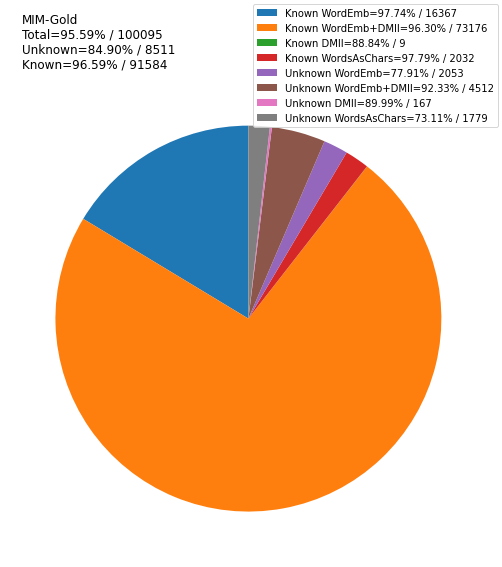

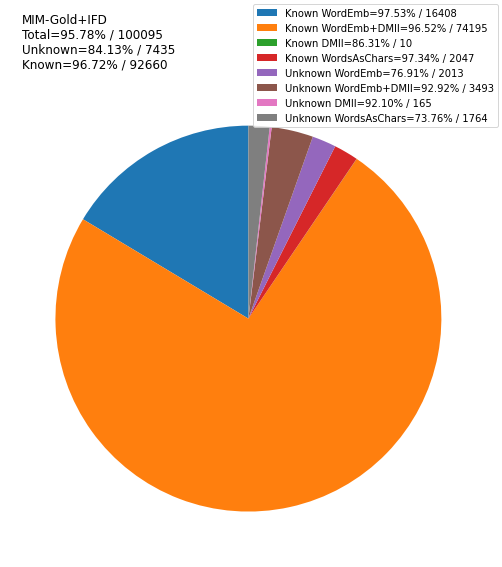

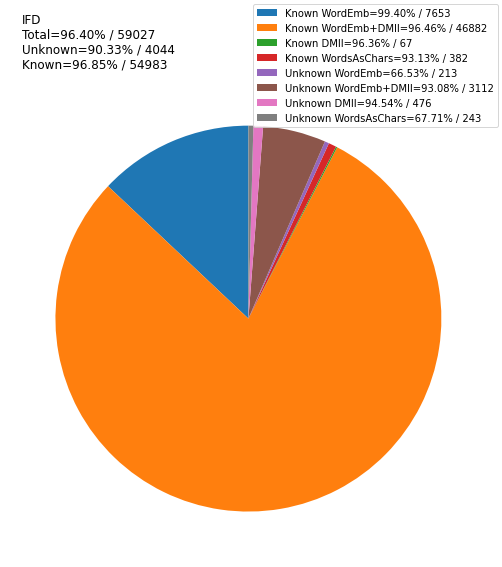

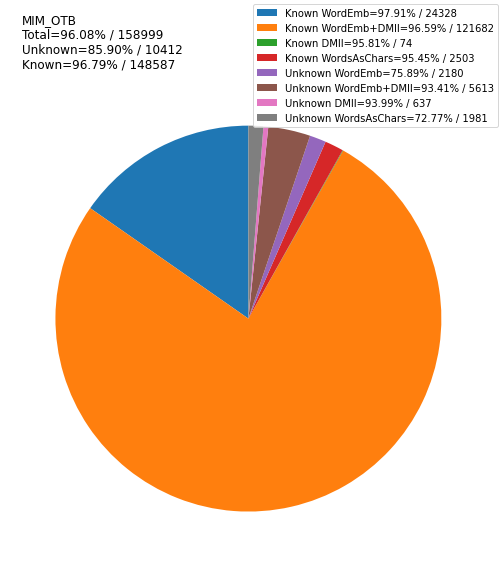

In [5]:
for name, average in averages:
    create_pie_chart(name, average, save_to=EXPERIMENT_DIR / f"{name}.png").show()

## Error profiles cummulative

In [24]:
error_profiles = {
    name: reduce(add, [experiment.error_profile() for experiment in experiments]) 
    for name, experiments in fold_experiments.items()
}
error_profile_total = {
    name: sum(value for key, value in error_profile.items())
    for name, error_profile in error_profiles.items()
}
with open("error_profiles.tsv", 'w') as f:
    for name, error_profile in error_profiles.items():
        print(name)
        counter = 1
        for key, value in error_profile.most_common(60):
            f.write(f"{counter}\t{key}\t{value}\t{value/error_profile_total[name]*100:.2f}\n")
            counter += 1

MIM-Gold
MIM-Gold+IFD
IFD
MIM_OTB


## Individual experiments
Define individual experiments, datasets and do analysis.


In [3]:
import os
print(os.getcwd())

/home/staff/haukurpj/ABLTagger/bin


In [3]:
from glob import glob
experiment_name = EXPERIMENT_DIR / "full-v2"
test_set_dir = "../data/pred"
test_sets = glob(f"{test_set_dir}/*.pred")
test_results = [evaluate.Experiment.from_file(experiment_name, predictions=test_ds) for test_ds in test_sets]

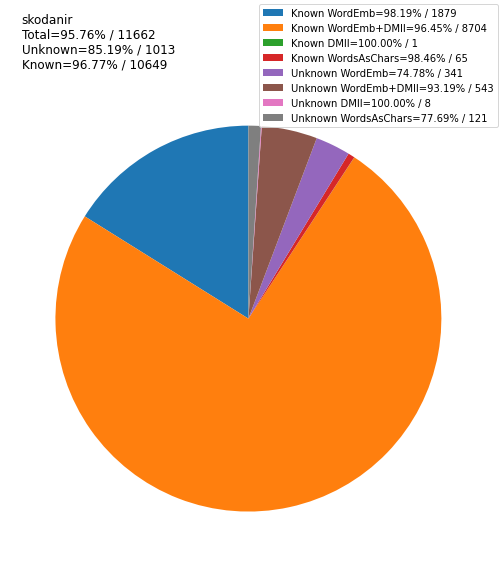

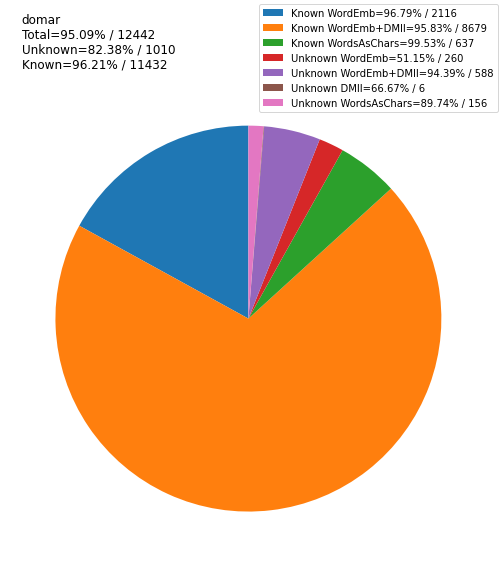

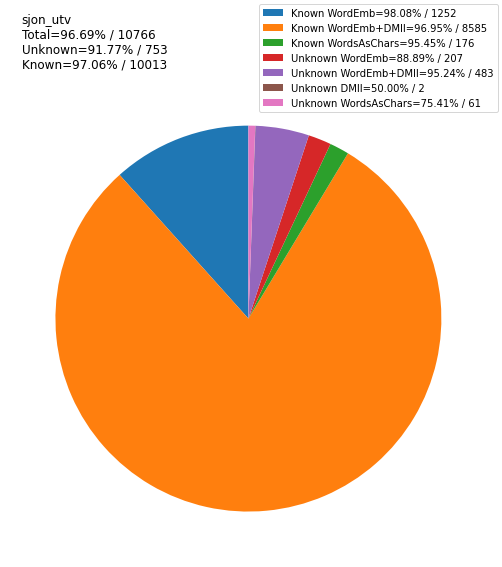

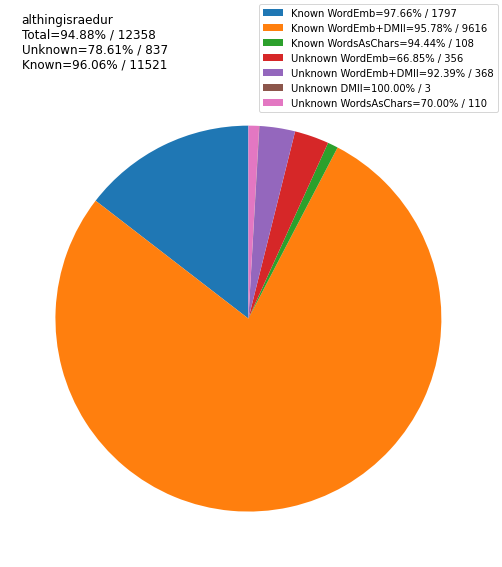

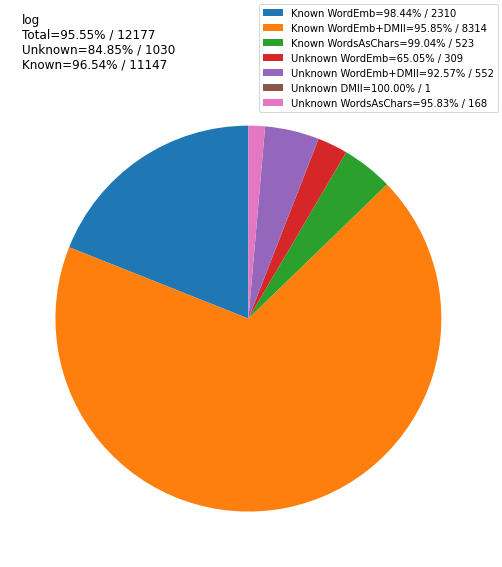

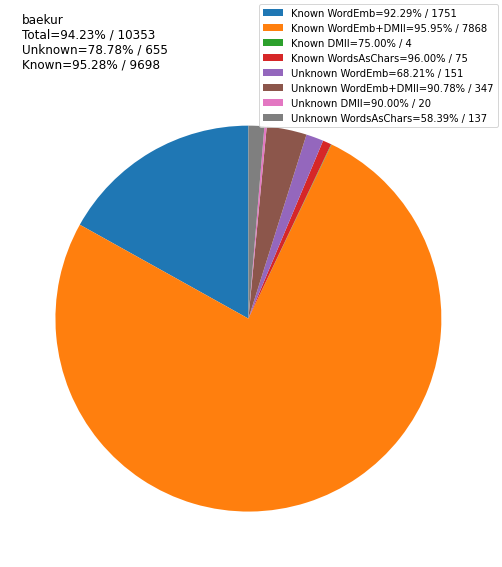

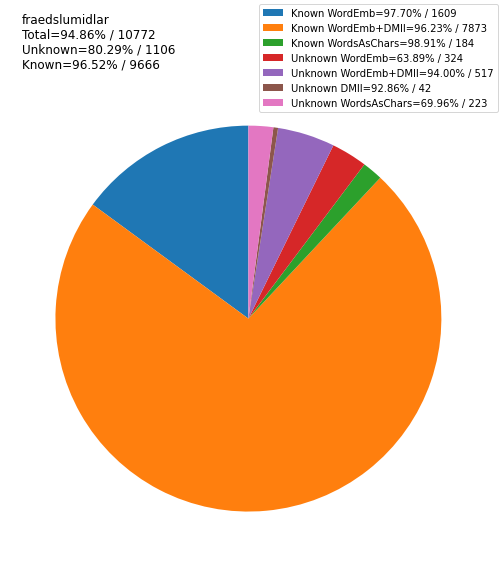

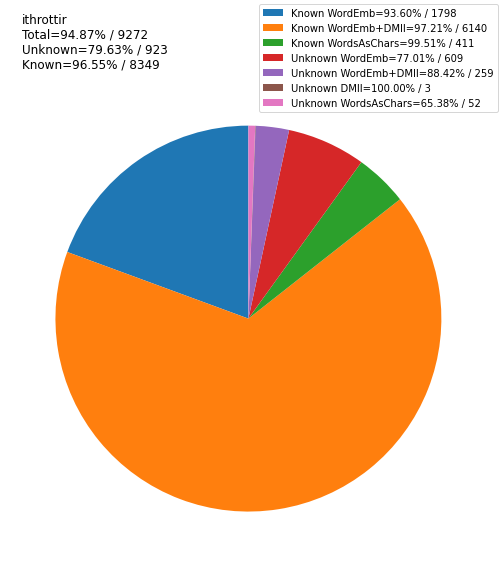

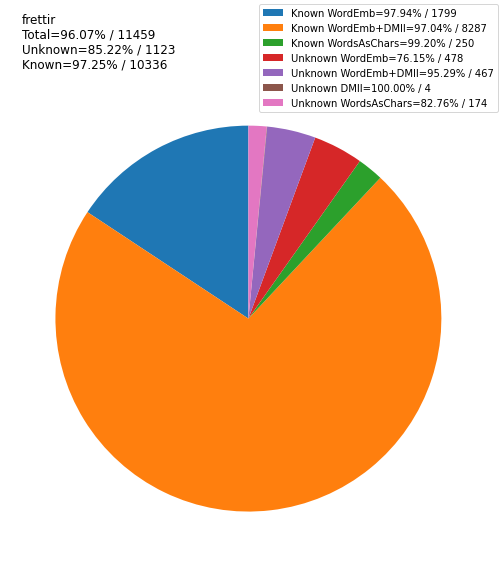

In [9]:
for experiment, name in zip(test_results, test_sets):
    name = Path(name).name.split(".")[0]  # the file names contain multiple "."
    fig, extra_art = create_pie_chart(name, experiment.all_accuracy())
    fig.savefig(f"{test_set_dir}/{name}.png", bbox_inches='tight', dpi=fig.dpi, bbox_extra_artists=extra_art)



### Errors
Proposed tag -> gold tag

In [11]:
def get_error_diff(baseline, compare_to):
    result = {}
    for key, value in baseline.items():
        if key not in compare_to:
            result[key] = basline[key]
            continue
        diff = baseline[key] - compare_to[key]
        if diff != 0:
            result[key] = diff
    return result

            

In [12]:
from collections import Counter
c_1 = Counter((1, 1, 2))
c_2 = Counter((1, 1, 3))
print(c_1 - c_2)

Counter({2: 1})


In [13]:
baseline = "sgd+morph_lex-freeze+wemb-pretrained-300-reduced-lr"
baseline_errors = evaluate.all_errors(experiments[baseline]["examples"])
for experiment_name in experiments:
    if experiment_name == baseline:
        continue
    print(f"{experiment_name}: First, in basline not in {experiment_name}, then in {experiment_name} not in basline.")
    pprint((evaluate.all_errors(experiments[baseline]["examples"]) - evaluate.all_errors(experiments[experiment_name]["examples"])).most_common(20))
    pprint((evaluate.all_errors(experiments[experiment_name]["examples"]) - evaluate.all_errors(experiments[baseline]["examples"])).most_common(20))

AttributeError: module 'pos.evaluate' has no attribute 'all_errors'